MLP Sentiment Analysis with Machine Learning

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.datasets import make_classification
from xgboost.sklearn import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D, Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [2]:
movie_reviews = pd.read_csv('rotten_tomatoes_reviews.csv')

In [3]:
movie_reviews.head()

,Freshness,Review
0,1,"Manakamana doesn't answer any questions, yet ..."
1,1,Wilfully offensive and powered by a chest-thu...
2,0,It would be difficult to imagine material mor...
3,0,Despite the gusto its star brings to the role...
4,0,If there was a good idea at the core of this ...


In [4]:
movie_reviews.shape

(480000, 2)

In [5]:
movie_reviews['Freshness'].value_counts()

1    240000
0    240000
Name: Freshness, dtype: int64

In [6]:
movie_reviews['Review'][0]

" Manakamana doesn't answer any questions, yet makes its point: Nepal, like the rest of our planet, is a picturesque but far from peaceable kingdom."

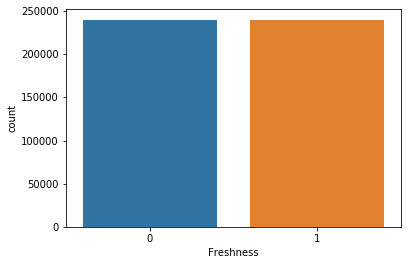

In [7]:
movie_reviews.isnull().sum()

sns.countplot(x='Freshness', data=movie_reviews)

In [8]:
def string_clean(text):
    
    # Remove all HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove all URL tags
    text = re.sub(r'^https?:\/\/.*[\r\n]*','',text)
    
    # Keep text without punctuation
    text = re.sub(r'[^\w\s]','',text)
    
    # convert text to lowercase
    text = text.strip().lower()

    # split text into a list of words
    # token_text = re.split('\W+',text)
    
    return text

In [9]:
movie_reviews['cleaned_review'] = movie_reviews['Review'].apply(lambda x: string_clean(x))

In [10]:
movie_reviews['cleaned_review'][0]

'manakamana doesnt answer any questions yet makes its point nepal like the rest of our planet is a picturesque but far from peaceable kingdom'

In [11]:
movie_reviews.head()

,Freshness,Review,cleaned_review
0,1,"Manakamana doesn't answer any questions, yet ...",manakamana doesnt answer any questions yet mak...
1,1,Wilfully offensive and powered by a chest-thu...,wilfully offensive and powered by a chestthump...
2,0,It would be difficult to imagine material mor...,it would be difficult to imagine material more...
3,0,Despite the gusto its star brings to the role...,despite the gusto its star brings to the role ...
4,0,If there was a good idea at the core of this ...,if there was a good idea at the core of this f...


In [12]:
def remove_stop_words(text):
    
    en_stopwords = list(nltk.corpus.stopwords.words('english'))
    text = [word for word in text.split() if word not in en_stopwords]
    
    # initialize an empty string 
    word_string = " " 
    
    # return string   
    return (word_string.join(text))

In [13]:
movie_reviews['stopped_review'] = movie_reviews['cleaned_review'].apply(lambda x: remove_stop_words(x))

In [14]:
movie_reviews = movie_reviews[['Review','cleaned_review','stopped_review','Freshness']]

In [15]:
movie_reviews.head()

,Review,cleaned_review,stopped_review,Freshness
0,"Manakamana doesn't answer any questions, yet ...",manakamana doesnt answer any questions yet mak...,manakamana doesnt answer questions yet makes p...,1
1,Wilfully offensive and powered by a chest-thu...,wilfully offensive and powered by a chestthump...,wilfully offensive powered chestthumping machi...,1
2,It would be difficult to imagine material mor...,it would be difficult to imagine material more...,would difficult imagine material wrong spade l...,0
3,Despite the gusto its star brings to the role...,despite the gusto its star brings to the role ...,despite gusto star brings role hard ride shotg...,0
4,If there was a good idea at the core of this ...,if there was a good idea at the core of this f...,good idea core film buried unsightly pile flat...,0


In [16]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

lemmatizer = WordNetLemmatizer()
p_stemmer = PorterStemmer()

In [17]:
def lemmatize_stemmer(text):
    
    text = [lemmatizer.lemmatize(i) for i in text.split()]
    text = [p_stemmer.stem(i) for i in text]
    
    # initialize an empty string 
    word_string = " " 
    # return string   
    return (word_string.join(text))

In [18]:
movie_reviews['final_review'] = movie_reviews['stopped_review'].apply(lambda x: lemmatize_stemmer(x))
movie_reviews = movie_reviews[['Review','cleaned_review','stopped_review','final_review','Freshness']]

In [19]:
movie_reviews.head()

,Review,cleaned_review,stopped_review,final_review,Freshness
0,"Manakamana doesn't answer any questions, yet ...",manakamana doesnt answer any questions yet mak...,manakamana doesnt answer questions yet makes p...,manakamana doesnt answer question yet make poi...,1
1,Wilfully offensive and powered by a chest-thu...,wilfully offensive and powered by a chestthump...,wilfully offensive powered chestthumping machi...,wil offens power chestthump machismo good clea...,1
2,It would be difficult to imagine material mor...,it would be difficult to imagine material more...,would difficult imagine material wrong spade l...,would difficult imagin materi wrong spade lost...,0
3,Despite the gusto its star brings to the role...,despite the gusto its star brings to the role ...,despite gusto star brings role hard ride shotg...,despit gusto star bring role hard ride shotgun...,0
4,If there was a good idea at the core of this ...,if there was a good idea at the core of this f...,good idea core film buried unsightly pile flat...,good idea core film buri unsightli pile flatul...,0


In [20]:
movie_reviews.to_csv('cleaned_reviews.csv',index=False)

In [20]:
X = movie_reviews['stopped_review']
#X_lemma = movie_reviews['final_review']
y = movie_reviews['Freshness']

In [23]:
def grid_searcher(X, y, vectorizer, model):
    
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.25,
                                                        random_state=42,
                                                        stratify=y)
    
    full_name_dict = {'cvec'     : 'Count Vectorizer',
                      'tvec'     : 'TfidfVectorizer',
                      'multi_nb' : 'MultinomialNB',
                      'lr'       : 'Logistic Regression',
                      'dt'       : 'Decision Tree Classifier',
                      'rf'       : 'Random Forest Classifier',
                      'ada'      : 'AdaBoost Classifier',
                      'gb'       : 'Gradient Boosting Classifier',
                      'xgb'      : 'XG Boost Classifier'
                     }
    
    vec_dict =  {'cvec': CountVectorizer(),
                 'tvec': TfidfVectorizer()
                }
    
    param_dict = {'cvec': {'cvec__max_features': [2500, 3000, 3500],
                           'cvec__min_df': [2, 3],
                           'cvec__max_df': [.9, .95],
                           'cvec__ngram_range': [(1,1), (1,2)]},
                  'tvec': {'tvec__max_features': [2500, 3000, 3500],
                           'tvec__min_df':[2,3],
                           'tvec__max_df':[.9,.95],
                           'tvec__ngram_range':[(1,1),(1,2)]},
                  'dt' : {'dt__max_depth': [3,5],
                          'dt__min_samples_split': [5,10],
                          'dt__min_samples_leaf': [2,3]},
                  'rf' : {'rf__n_estimators': [100],
                          'rf__max_depth': [None, 1, 2],
                          'rf__min_samples_split': [5,10],
                          'rf__min_samples_leaf': [2,3]},
                  'lr' : {},
                  'multi_nb' : {},
                  'ada': {'ada__n_estimators':[50,80],
                          'ada__algorithm': ['SAMME', 'SAMME.R'],
                          'ada__learning_rate': [0.9, 1.]
                          },
                  'gb': {'gb__max_depth': [2,3,4],
                          'gb__n_estimators': [100, 125],
                          'gb__learning_rate': [.08, .1]},
                  'xgb': {}                    
                  }

    model_dict = {'multi_nb' : MultinomialNB(),
                  'lr' : LogisticRegression(solver='lbfgs', max_iter = 1000),
                  'dt' : DecisionTreeClassifier(),
                  'rf' : RandomForestClassifier(),
                  'ada': AdaBoostClassifier(),
                  'gb' : GradientBoostingClassifier(),
                  'xgb' : XGBClassifier()
                  }
    
    pipe = Pipeline([(vectorizer, vec_dict[vectorizer]), 
                    ((model, model_dict[model]))])
    
    
    param_dict[model].update(param_dict[vectorizer])
    pipe_params = param_dict[model]
    
    grid = GridSearchCV(pipe,
           param_grid=pipe_params,
           cv=3)
        
    grid.fit(X_train, y_train)
    
    print(f'Using {full_name_dict[model]} Model and {full_name_dict[vectorizer]}:')
    print(f'Model train score : {grid.best_score_}')
    print(f'Model test score : {grid.score(X_test,y_test)}')
    print(f'Model best params : {grid.best_params_}')

In [22]:
grid_searcher(X,y,'cvec','lr')

Using Logistic Regression Model and Count Vectorizer:
Model train score : 0.76445
Model test score : 0.766675
Model best params : {'cvec__max_df': 0.9, 'cvec__max_features': 3500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}


In [23]:
grid_searcher(X,y,'tvec','lr')

Using Logistic Regression Model and TfidfVectorizer:
Model train score : 0.7647027777777777
Model test score : 0.7670833333333333
Model best params : {'tvec__max_df': 0.9, 'tvec__max_features': 3500, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2)}


In [24]:
grid_searcher(X,y,'cvec','dt')

Using Decision Tree Classifier Model and Count Vectorizer:
Model train score : 0.5213166666666667
Model test score : 0.518825
Model best params : {'cvec__max_df': 0.9, 'cvec__max_features': 2500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'dt__max_depth': 5, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 5}


In [25]:
grid_searcher(X,y,'tvec','dt')

Using Decision Tree Classifier Model and TfidfVectorizer:
Model train score : 0.521425
Model test score : 0.5188
Model best params : {'dt__max_depth': 5, 'dt__min_samples_leaf': 3, 'dt__min_samples_split': 5, 'tvec__max_df': 0.9, 'tvec__max_features': 3500, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 1)}


In [26]:
grid_searcher(X,y,'cvec','multi_nb')

Using MultinomialNB Model and Count Vectorizer:
Model train score : 0.7557583333333333
Model test score : 0.7565
Model best params : {'cvec__max_df': 0.9, 'cvec__max_features': 3500, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1)}


In [27]:
grid_searcher(X,y,'tvec','multi_nb')

Using MultinomialNB Model and TfidfVectorizer:
Model train score : 0.7556805555555556
Model test score : 0.7560416666666666
Model best params : {'tvec__max_df': 0.9, 'tvec__max_features': 3500, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 1)}


In [30]:
grid_searcher(X,y,'cvec','xgb')

Using XG Boost Classifier Model and Count Vectorizer:
Model train score : 0.6412527777777778
Model test score : 0.6426333333333333
Model best params : {'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2)}


In [31]:
grid_searcher(X,y,'tvec','xgb')

Using XG Boost Classifier Model and TfidfVectorizer:
Model train score : 0.6438277777777778
Model test score : 0.6442333333333333
Model best params : {'tvec__max_df': 0.9, 'tvec__max_features': 3500, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}


In [24]:
X = movie_reviews['final_review']
y = movie_reviews['Freshness']

In [25]:
grid_searcher(X,y,'cvec','lr')

Using Logistic Regression Model and Count Vectorizer:
Model train score : 0.7682277777777777
Model test score : 0.768275
Model best params : {'cvec__max_df': 0.9, 'cvec__max_features': 3500, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1)}


In [26]:
grid_searcher(X,y,'tvec','lr')

Using Logistic Regression Model and TfidfVectorizer:
Model train score : 0.7683638888888888
Model test score : 0.7683083333333334
Model best params : {'tvec__max_df': 0.9, 'tvec__max_features': 3500, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}


In [27]:
grid_searcher(X,y,'cvec','multi_nb')

Using MultinomialNB Model and Count Vectorizer:
Model train score : 0.7591638888888889
Model test score : 0.7595333333333333
Model best params : {'cvec__max_df': 0.9, 'cvec__max_features': 3500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}


In [28]:
grid_searcher(X,y,'tvec','multi_nb')

Using MultinomialNB Model and TfidfVectorizer:
Model train score : 0.7586861111111111
Model test score : 0.7586833333333334
Model best params : {'tvec__max_df': 0.9, 'tvec__max_features': 3500, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}


In [29]:
grid_searcher(X,y,'cvec','dt')

Using Decision Tree Classifier Model and Count Vectorizer:
Model train score : 0.5292638888888889
Model test score : 0.523125
Model best params : {'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'dt__max_depth': 5, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 5}


In [30]:
grid_searcher(X,y,'tvec','dt')

Using Decision Tree Classifier Model and TfidfVectorizer:
Model train score : 0.5302055555555556
Model test score : 0.5231333333333333
Model best params : {'dt__max_depth': 5, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 5, 'tvec__max_df': 0.9, 'tvec__max_features': 3500, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}


In [31]:
grid_searcher(X,y,'cvec','xgb')

Using XG Boost Classifier Model and Count Vectorizer:
Model train score : 0.6508611111111111
Model test score : 0.652775
Model best params : {'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}


In [32]:
grid_searcher(X,y,'tvec','xgb')

Using XG Boost Classifier Model and TfidfVectorizer:
Model train score : 0.6519388888888888
Model test score : 0.6531083333333333
Model best params : {'tvec__max_df': 0.9, 'tvec__max_features': 3500, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}
